In [77]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [78]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [79]:
data_dir

WindowsPath('C:/Users/user/.keras/datasets/flower_photos')

# keras 유틸리티 사용하여 데이터 로드
 - 사용자가 설정한 배치크기만큼 x,y 데이터셋을 제작하는 과정
    - 이미지크기를 지정한 사이즈로 통일
    - x데이터를 세트로 array
    - y값은 폴더이름에 따라서 순차적으로 0,1,2... index 부여
    - 폴더이름을 class_names에 할당
 - x,y값을 사용자가 지정한 비율에 맞춰서 train, test로 분리

In [80]:
# 총 3670개 자료
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [81]:
batch_size = 32
img_height = 180
img_width = 180

In [82]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,           # traindata의 검증
    subset="training",              # 너의 이름은 training이다
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,           # testdata의 검증
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [83]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [84]:
'''
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    """
    validation_split=0.2,           # 만약 처음부터 나뉘어 있었다면 얘네 둘은 필요 없음
    subset="validation",
    """
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
'''

'\nval_ds = tf.keras.utils.image_dataset_from_directory(\n    data_dir,\n    """\n    validation_split=0.2,           # 만약 처음부터 나뉘어 있었다면 얘네 둘은 필요 없음\n    subset="validation",\n    """\n    seed=123,\n    image_size=(img_height, img_width),\n    batch_size=batch_size)\n'

In [85]:
len(list(train_ds))

92

In [86]:
# 32개의 이미지와 레이블이 있는 92개 중 1번
list(train_ds)[0]

(<tf.Tensor: shape=(32, 180, 180, 3), dtype=float32, numpy=
 array([[[[8.83888855e+01, 1.24388885e+02, 2.00388885e+02],
          [8.89277802e+01, 1.24927780e+02, 2.00927780e+02],
          [8.88342590e+01, 1.25369446e+02, 1.99212967e+02],
          ...,
          [2.14580017e+02, 8.65392227e+01, 2.93608099e-01],
          [2.33405533e+02, 1.02674973e+02, 5.17222071e+00],
          [2.28703690e+02, 9.76851730e+01, 2.50831127e+00]],
 
         [[9.02777786e+01, 1.26277779e+02, 2.02277786e+02],
          [9.08666611e+01, 1.27150002e+02, 2.03008331e+02],
          [9.50527802e+01, 1.33036102e+02, 2.06155548e+02],
          ...,
          [1.61444641e+02, 6.94110336e+01, 9.16383362e+00],
          [1.72708313e+02, 6.47249908e+01, 1.37494326e+00],
          [1.53869415e+02, 6.37055588e+01, 4.15557909e+00]],
 
         [[9.30277786e+01, 1.31027786e+02, 2.06027786e+02],
          [9.27500000e+01, 1.30819443e+02, 2.05819443e+02],
          [9.83518524e+01, 1.37162033e+02, 2.09879623e+02],
    

In [87]:
# 32개의 이미지와 레이블이 있는 92개 중 1번의 레이블
list(train_ds)[0][1]

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 2, 3, 3, 1, 2, 4, 4, 4, 4, 1, 4, 3, 1, 2, 1, 0, 3, 3, 0, 4, 3,
       3, 1, 4, 1, 4, 4, 1, 1, 1, 1])>

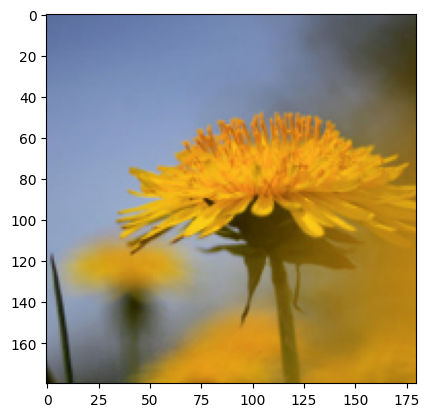

In [88]:
# 32개의 이미지 중 첫번째 이미지
img = list(train_ds)[0][0][1].numpy().astype("uint8")
plt.imshow(img)

In [89]:
# 버퍼링된 프리페치를 사용하여 I/O를 차단하지 않고 디스크에서 데이터를 생성
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Modeling

In [90]:
data_augmentation = keras.Sequential(
    [
    layers.RandomFlip("horizontal",
                        input_shape=(img_height,
                                    img_width,
                                    3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    ]
)

In [101]:
num_classes = len(class_names)

# input size (180,180)
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),#, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(), # (90,90)
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),  # (45,45)
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(), # (23,23,64)
    layers.Dropout(0.2),  
    layers.Flatten(), # 23*23*64
    layers.Dense(128, activation='relu'), 
    layers.Dense(num_classes, activation='softmax')
])

In [102]:
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [103]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

In [104]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10


92/92 [==============================] - 3s 22ms/step - loss: 1.3762 - accuracy: 0.4080 - val_loss: 1.1002 - val_accuracy: 0.5341
Epoch 2/10
92/92 [==============================] - 2s 20ms/step - loss: 1.0406 - accuracy: 0.5879 - val_loss: 1.0035 - val_accuracy: 0.6117
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 0.9590 - accuracy: 0.6236 - val_loss: 0.9799 - val_accuracy: 0.6253
Epoch 4/10
92/92 [==============================] - 2s 20ms/step - loss: 0.8933 - accuracy: 0.6557 - val_loss: 0.9419 - val_accuracy: 0.6322
Epoch 5/10
92/92 [==============================] - 2s 20ms/step - loss: 0.8440 - accuracy: 0.6686 - val_loss: 0.8430 - val_accuracy: 0.6499
Epoch 6/10
92/92 [==============================] - 2s 20ms/step - loss: 0.7759 - accuracy: 0.7084 - val_loss: 0.8663 - val_accuracy: 0.6553
Epoch 7/10
92/92 [==============================] - 2s 20ms/step - loss: 0.7534 - accuracy: 0.7119 - val_loss: 0.7783 - val_accuracy: 0.6948
Epoch 8/10
92/92 [======

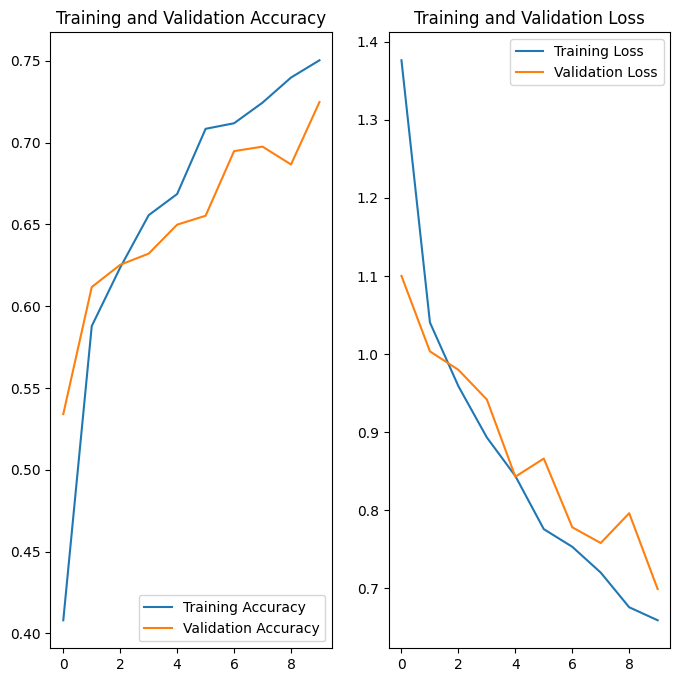

In [105]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 과적합 방지
 - 데이터증강
 - 드롭아웃
## model save

In [ ]:
from PIL import Image
img = Image.open("path.jpg").resize((180,180))
img=np.array(img)
img=np.reshape(img,(1,180,180,3))
predict=model.predict(img)

predictNum = np.argmax(predict)
class_names[predictNum]